In [1]:
%matplotlib inline
import cv2
import os,sys
import pickle
import scipy.stats
import sklearn.metrics

import matplotlib
import matplotlib.image as mpimg
import matplotlib.cm as cm # To color dots of scatter plots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from skimage.feature import hog
from scipy.stats import norm
from sklearn import preprocessing
from itertools import combinations
from PIL import Image

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [176]:
import sys
sys.path.insert(1, './utilities/')

from utility_functions import *

# Load the Data

In [3]:
# Loaded a set of images
root_dir = "../../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


# Data Preprocessing

## Split the images into smaller patches

In [4]:
n = 10 # Only use 10 images for training
# Extract patches from input images
# size = 10(nb_images)*625(n_patches_per_image)*16*16(size_patch)*3(nb_channels)
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
#return array of size 6250 containing all the 625 patches for all the 10 training images
#gt has only 0 or 1 values
#img has an rgb value of size 3 for each point

# Extraction of Features from the images

In [159]:
def threshold_eroded_img(img):
    img = rgb2gray(img)
    #plt.imshow(img)
    #plt.show()
    img = img_float_to_uint8(img)
    ret,thresh1 = cv2.threshold(img,70,255,cv2.THRESH_BINARY)
    #plt.imshow(thresh1)
    #plt.show()
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(thresh1,kernel,iterations = 1)
    dilated = cv2.dilate(erosion,kernel,iterations = 1)
    #plt.imshow(dilated)
    #plt.show()
    
    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = 1300  

    #your answer image
    img2 = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    #plt.imshow(img2)
    #plt.show()
        
    feat_vert = np.sum(erosion, axis=1) / 255 / erosion.shape[1]
    feat_hori = np.sum(erosion, axis=0) / 255 / erosion.shape[0]
    
    feat_vert[feat_vert < 0.35] = 0
    feat_hori[feat_hori < 0.35] = 0
    #plt.bar(range(erosion.shape[0]), feat_hori)
    #plt.bar(range(erosion.shape[0]), feat_vert)
    #plt.show()
    return np.hstack((feat_vert,feat_hori))

res =threshold_eroded_img(imgs[3])

In [161]:
#a faire sur l'image entière plutot
def hog_features(image):
    #histogram of oriented gradients
    grey_bombus = rgb2gray(image)
    hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(5,5))
        
    #plt.imshow(hog_image, cmap=cm.gray)
    return hog_image

hog_features(imgs[3])

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00891252, 0.02937   , ..., 0.03056435, 0.        ,
        0.        ],
       [0.        , 0.03696758, 0.0165101 , ..., 0.02280518, 0.00519546,
        0.        ],
       ...,
       [0.        , 0.02844387, 0.02762106, ..., 0.01024096, 0.00403496,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [162]:
#3 new features
import mahotas

def fd_hu_moments(image):
    image = img_float_to_uint8(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
def fd_haralick(image):    # convert the image to grayscale
    image = img_float_to_uint8(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick
 
#fd hist ne marche pas encore
def fd_histogram(image, mask=None):
    image = img_float_to_uint8(image)
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    # documentation: cv.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
    hist  = cv2.calcHist([image], [0, 1, 2], None, [3, 3, 3], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    hist.flatten()
    
print(fd_hu_moments(imgs[3]))
print(fd_haralick(imgs[3]) ) 

[2.36089089e-03 1.31989277e-09 2.95904967e-12 7.73801105e-12
 4.66044940e-24 9.55746477e-17 3.67326717e-23]
[ 1.88039899e-04  9.03837665e+02  7.84923668e-01  2.10103189e+03
  1.20263066e-01  1.40146298e+02  7.50028990e+03  8.21881821e+00
  1.34113709e+01  1.30991713e-04  5.49662066e+00 -1.61067899e-01
  9.45007905e-01]


In [163]:
#Features definition
def features_definition(img_patches):
    print("compute X1")
    X1 = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))]) # dim 6
    print("Added dims: " + str(X1.shape[1]))
    X2 = np.asarray([ laplace_gaussian_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 32
    print("Added dims: " + str(X2.shape[1]))
    X3 = np.asarray([ horizontal_and_vertical_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 32
    print("Added dims: " + str(X3.shape[1]))
    X4 = np.asarray([ get_grey_features(get_gray_mask(img_patches[i])) for i in range(len(img_patches))]) # dim 32
    #X4 = np.asarray([ get_gray_mask(img_patches[i]).ravel() for i in range(len(img_patches))]) # dim 16 * 16
    print("Added dims: " + str(X4.shape[1]))
    X5 = np.asarray([ threshold_eroded_img(img_patches[i]) for i in range(len(img_patches))]) # dim 32
    print("Added dims: " + str(X5.shape[1]))
    X6 = np.asarray([ fd_hu_moments(img_patches[i]) for i in range(len(img_patches))]) # dim 7
    print("Added dims: " + str(X6.shape[1]))
    X7 = np.asarray([ fd_haralick(img_patches[i]) for i in range(len(img_patches))]) # dim 13
    print("Added dims: " + str(X7.shape[1]))
    X8 = np.asarray([ hog_features(img_patches[i]).ravel() for i in range(len(img_patches))]) # dim 16 * 16
    print("Added dims: " + str(X8.shape[1]))
    print("stop")
    X = np.concatenate((X1,X2,X3,X4,X6,X7,X8),axis=1) # dim 402
    #X = feature_expansion(X,4) # dim = dim * degree
    X = feature_interaction(X) # dim = dim**2
    X = add_offset(X) # dim = dim + 1
    print(X.shape)

    return X

In [164]:
X = features_definition(img_patches)

compute X1
Added dims: 6
Added dims: 32
Added dims: 32
Added dims: 32
Added dims: 32
Added dims: 7
Added dims: 13
Added dims: 256
stop
(6250, 379)


In [193]:
#normalization
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

### Definition of the output y

In [166]:
### Definition of two classes for the patches

# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

#the class foreground has a bit of road in it (25% min)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

### Statistics on computed features 

In [194]:
# Print feature statistics
print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 143641
Number of classes = 1
Class 0: 4915 samples
Class 1: 1335 samples


In [ ]:
def hist_of_features(X):
    """
    performs a histogram of the distribution of all the parameters in the dataset 
    parameters:
        X: the dataset to plot
    """
    n = X.shape[1]
    fig, ax = plt.subplots(4,5)

    for i in range(4):
        for j in range(5):
            ax[i,j].hist(X[:,i+j], bins = 30)
            ax[i,j].set_title(i+j,fontsize=40)
        
    fig.set_figheight(150)
    fig.set_figwidth(150)
    plt.suptitle("Distribution of all the features",fontsize=150)
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.show()
    
hist_of_features(X)

## PCA and Plots

[9.90520631e-01 9.28630029e-03 1.92965816e-04 7.26973361e-08
 1.78683753e-08 2.30121449e-09 1.85292239e-09 9.23836982e-10
 9.06361477e-10 5.92138951e-10] (300, 6250)


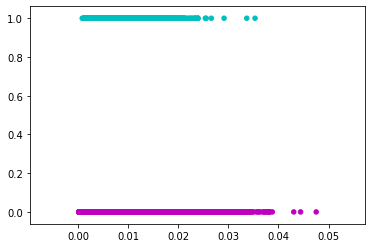

In [195]:
pca = PCA(n_components=300)
pca.fit(X.T)  
colors = ['c' if yi else 'm' for yi in Y]
print(pca.explained_variance_ratio_[:10], pca.components_.shape)  
plt.scatter(pca.components_[0],Y, s=20, c=colors)
#first component explains 99% variance -> but still no clear separation between y1 and y0
    
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


0.010600244004293331 4.763482704944325e-05
(array([], dtype=int64),) (6250,)


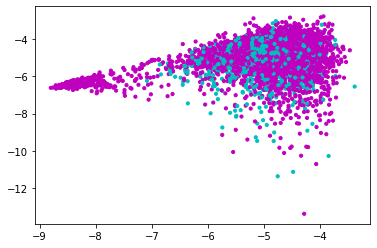

In [199]:
plt.scatter(np.log(pca.components_[0]),np.log(pca.components_[1]), s=10, c=colors)
print(np.mean(pca.components_[0]), np.var(pca.components_[0]))
print(np.where(pca.components_[1] > 0.1), pca.components_[0].shape)

# Training of the model

In [168]:
#define parameters
proportion_class0 = (len(Y0)) / (len(Y))
proportion_class1 = (len(Y1)) / (len(Y))
print(proportion_class0,proportion_class1)
weight = {0:proportion_class1, 1:proportion_class0}

0.7864 0.2136


## 1) Logistic regression

In [ ]:
# train a logistic regression classifier
from sklearn import linear_model
import time

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e4,solver='liblinear',penalty='l1',class_weight=weight,verbose=3)
# Run the estimation
start = time.time()
logreg.fit(pca.components_.T, Y)
stop = time.time()
print(stop - start)

In [ ]:
print(X.shape)

In [ ]:
# Predict on the training set
Z = logreg.predict(pca.components_.T)

In [ ]:
#Best score yet: 0.230769

## 2) SVM

In [200]:
#in general the SVM performs better than the LogReg model
from sklearn import svm
#pca.components_.T

clf = svm.SVC(C=10, cache_size=200, class_weight=weight, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
clf.fit(pca.components_.T, Y)  

[LibSVM]

SVC(C=10, cache_size=200, class_weight={0: 0.2136, 1: 0.7864}, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [201]:
# Predict on the training set
Z = clf.predict(pca.components_.T)

## Model evaluation

In [202]:
#F1 Score
calculate_f1_score(Y,Z)

0.9319298245614036

In [203]:
#accuracy
print(np.sum(Z==Y)/ Z.shape[0])

0.96896


In [209]:
# Loaded a set of images
root_dir_test = "../../Datasets/test_set_images/test_"

n=10
print("Loading " + str(n) + " images")
test_imgs = []
for i in range(n-1):
    image_dir_test = root_dir + str(i+1) + "/"
    file = os.listdir(image_dir)
    print("Loading " + str(file))
    imgs.append(load_image(image_dir + file[0]))

Loading 10 images
Loading ['test_1.png']
Loading ['test_2.png']
Loading ['test_3.png']
Loading ['test_4.png']
Loading ['test_5.png']
Loading ['test_6.png']
Loading ['test_7.png']
Loading ['test_8.png']
Loading ['test_9.png']


# Display of results

In [210]:
#TODO: pour vérifier resultats
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx],patch_size)
Zi = clf.predict(Xi)
plt.scatter(Xi[:, 1], Xi[:, 10], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

FileNotFoundError: [Errno 2] No such file or directory: '../../Datasets/test_set_images/test_9/satImage_092.png'

In [ ]:
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

## Submission

In [ ]:
n = 4 # Only use 10 images for test
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])

In [ ]:
#TODO: make feature mat from test_set data and make predictions and then the csv

# Experimental features

In [ ]:
#important feature detection (corners)
from skimage.feature import CENSURE
from skimage.color import rgb2gray

def corner_detection(image):
    image = image.astype('double')
    img_orig = rgb2gray(image)
    detector = CENSURE(min_scale=1,max_scale=3,mode='STAR',non_max_threshold=0.1,line_threshold=100)
    detector.detect(img_orig)

    feat_x = detector.keypoints[:, 0]
    feat_y = detector.keypoints[:, 1]
  
    unique_val, counts = np.unique(feat_x, return_counts=True)
    feat_x = unique_val[np.where(counts > 3)]
    unique_val, counts = np.unique(feat_y, return_counts=True)
    feat_y = unique_val[np.where(counts > 3)]
    print(feat_x)
    
    plt.hist(feat_x, bins=20)
    plt.show()
    plt.hist(feat_y, bins=20)
    plt.show()
    
    plt.hist(np.convolve(feat_x, np.ones(10), mode='full'))
    plt.show()
    
    plt.title('CENSURE feature detection')
    plt.imshow(img_orig)
    plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
            2 ** detector.scales, facecolors='none', edgecolors='r')
    
corner_detection(imgs[6])
plt.imshow(gt_imgs[6])

In [ ]:
#line detection
#TODO: transformer ca en feature
def proba_hough_tranform(img):
    img = img_float_to_uint8(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #edges = cv2.Canny(gray,50,150,apertureSize = 3)
    edges = ndimage.gaussian_laplace(gray, sigma=2.5)
    features = np.zeros_like(2*img.shape[0])
    
    #plt.imshow(edges)
    #plt.show()
    minLineLength = 100
    maxLineGap = 120
    lines = cv2.HoughLinesP(edges,0.01,np.pi/360,100,minLineLength,maxLineGap)
    for i in range(len(lines)):
        #print(lines[i])
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
            
    #cv2.imwrite('houghlines5.jpg',img)
    plt.imshow(img)
    plt.show()
    
    return features
   
proba_hough_tranform(imgs[3])
plt.imshow(gt_imgs[3])